In [5]:
%matplotlib inline
from matplotlib import pyplot as plt

In [6]:
from sklearn.feature_extraction import image
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from skimage import feature, exposure, io
import mahotas
from PIL import Image
import cv2 as cv


import os
import pickle as pc

import numpy as np
import pandas as pd

In [7]:
df = pd.read_csv('data/datos-raw-train.csv')

In [8]:
df_train = df[['artistName', 'image', 'title', 'year', 'estilo']].copy()

In [9]:
df_train['image'] = df_train['image'].apply(lambda x: x.split('/')[-1])

In [10]:
df_train.head()

,artistName,image,title,year,estilo
0,Jean-Baptiste-Simeon Chardin,jean-baptiste-sime-on-chardin-017.jpg,Woman Cleaning Turnips,1740,realism
1,Th&#233;odore G&#233;ricault,the-wounded-cuirassier.jpg,The Wounded Cuirassier,1814,realism
2,Th&#233;odore G&#233;ricault,the-three-skulls-1814.jpg,The&#160;three skulls,1812-1814,realism
3,Th&#233;odore G&#233;ricault,wounded-cuirassier.jpg,Wounded Cuirassier,1814,realism
4,Th&#233;odore G&#233;ricault,the-wounded-cuirassier-1814.jpg,The Wounded Cuirassier,1814,realism


In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 5 columns):
artistName    2400 non-null object
image         2400 non-null object
title         2400 non-null object
year          2400 non-null object
estilo        2400 non-null object
dtypes: object(5)
memory usage: 93.8+ KB


In [196]:
#estilos = ['realism', 'surrealism', 'abstract-art', 'pop-art']
estilos = ['abstract-art', 'realism']

In [113]:
#imagen de prueba


path = 'imagenes_color/train/realism/'
archivo_nombre = os.path.join(path + 'a-boy-in-a-red-shirt.jpg')
imagen = cv.imread(archivo_nombre) #, cv.IMREAD_GRAYSCALE) cv.cvtColor(imagen, cv.COLOR_BGR2GRAY)


In [114]:
def uno_estilo(estilos):
    imagenes = []
    for e in estilos:
        path = 'imagenes_color/train/{}/'.format(e)
        imagen = cv.imread([os.path.join(path, p) for p in sorted(os.listdir(path))][1])
        imagenes.append(imagen)
        
    return imagenes

In [115]:
una_de_cada = uno_estilo(estilos)
#una_de_cada

In [169]:
path_train = 'imagenes_color/train/'
path_test = 'imagenes_color/test/'
path_validar = 'imagenes_color/validar/'

#### Local features

In [158]:
sift = cv.xfeatures2d.SIFT_create()
surf = cv.xfeatures2d.SURF_create()
orb = cv.ORB_create(nfeatures = 256)

In [159]:
keypoints_sift, descriptors = sift.detectAndCompute(imagen, None)
keypoints_surf, descriptors = surf.detectAndCompute(imagen, None)
keypoints_orb, descriptors = orb.detectAndCompute(imagen, None)

In [160]:
img = cv.drawKeypoints(imagen, keypoints_surf, None)
cv.imshow("Imagen", img)
cv.waitKey(25)
cv.destroyAllWindows()

#### Global features

In [170]:
#Prueba de feature
def hu_moments(imagen):
    imagen = cv.cvtColor(imagen, cv.COLOR_BGR2GRAY)
    feature = cv.HuMoments(cv.moments(imagen)).flatten()
    return feature

In [171]:
hu_moments(imagen)

array([ 2.13724515e-03,  2.63622425e-07,  5.51111555e-13,  2.50586488e-11,
       -8.22056414e-23, -7.68021586e-15, -4.37503906e-23])

In [172]:
def textura(imagen):
    gris = cv.cvtColor(imagen, cv.COLOR_BGR2GRAY)
    haralick = mahotas.features.haralick(gris).mean(axis=0)
    return haralick

In [173]:
textura(imagen)

array([ 2.46453468e-03,  3.35164924e+01,  9.80501042e-01,  8.59232345e+02,
        2.90799410e-01,  1.42409724e+02,  3.40341289e+03,  7.01961062e+00,
        1.01186092e+01,  5.20593523e-04,  3.39969386e+00, -3.47860538e-01,
        9.88361636e-01])

In [174]:
def histograma(imagen, mask = None):
    hist = cv.calcHist([imagen],[0], None, [256], [0,256])
    cv.normalize(hist, hist)
    return hist.flatten()

In [175]:
img_hist = histograma(imagen)

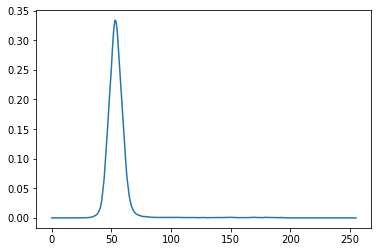

In [176]:
plt.plot(img_hist)

In [177]:
def histograma_color(imagen, mask = None):
    imagen = cv.cvtColor(imagen, cv.COLOR_BGR2HSV)
    hist  = cv.calcHist([imagen], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    cv.normalize(hist, hist)
    return hist.flatten()

In [178]:
def prueba_histo(imagen):
 
    img_hog = feature.hog(imagen, orientations=9, pixels_per_cell=(8, 8),
                     cells_per_block=(1, 1))
 
    return img_hog

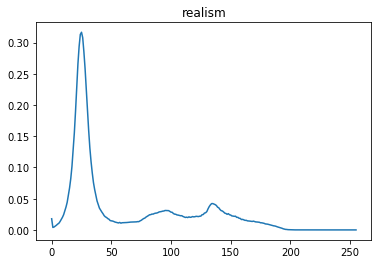

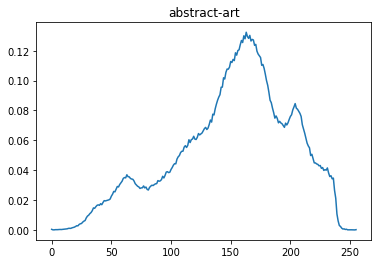

<Figure size 432x288 with 0 Axes>

In [179]:
for i in range(len(una_de_cada)):
    probando_hist = histograma(una_de_cada[i])
    plt.plot(probando_hist)
    plt.title(estilos[i])
    plt.figure()

In [199]:
# Para guardar la features en un pickle
def features_imagenes(path, archivo, label_a):
    '''
    almacena todas las features en un archivo pickle
    path: ruta de las imágenes
    archivo: nombre para el pickle
    '''
    label = []
    feature = []
    for e in estilos:
        archivos = [os.path.join(path+e, p) for p in sorted(os.listdir(path+e))]
        #feature = {}


        print(e)
        for a in archivos:
            #print('Feature de {}'.format(a))

            imagen = a.split('/')[-1].lower()
            img_arch = cv.imread(a)
            img_arch = cv.resize(img_arch, tamano)

            hu = hu_moments(img_arch)
            haralick_im   = textura(img_arch)
            histograma_im  = histograma_color(img_arch)

            features_imagen = np.hstack([histograma_im, haralick_im, hu])            
            
            label.append(e)
            feature.append(features_imagen)
            #print(feature)
            with open('features/' + archivo, 'wb') as fp:
                pc.dump(feature, fp)
                
            with open('features/' + label_a, 'wb') as lp:
                pc.dump(label, lp)            
            
    print(len(feature))
    print(len(label))


In [200]:
a_label = 'label-train.pck'
features_imagenes(path_train, 'features-train.pck', a_label)

abstract-art
realism
1186
1186


In [201]:
arch_feature = ''
with (open('features/features-train.pck', 'rb')) as pc_file:
    try:
        arch_feature = pc.load(pc_file)
    except EOFError as e:
        print(e)

In [202]:
arch_label = ''
with (open('features/label-train.pck', 'rb')) as pc_file:
    try:
        arch_label = pc.load(pc_file)
    except EOFError as e:
        print(e)

In [203]:
print('Features {}'.format(np.array(arch_feature).shape))
print('Labels {}'.format(np.array(arch_label).shape))

Features (1186, 532)
Labels (1186,)


In [204]:
targetNames = np.unique(arch_label)
le = LabelEncoder()
target = le.fit_transform(arch_label)

scaler = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(arch_feature)


In [205]:
# Probando modelos

In [206]:
import h5py
import numpy as np
import os
import glob
import cv2
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.externals import joblib

In [207]:
(X_train, X_test, y_train, y_test) = train_test_split(np.array(rescaled_features),
                                                      np.array(target),
                                                      test_size = 0.2,
                                                      random_state = 10)

print("Train data  : {}".format(X_train.shape))
print("Test data   : {}".format(X_test.shape))
print("Train etiquetas: {}".format(y_train.shape))
print("Test etiquetas : {}".format(y_test.shape))

Train data  : (948, 532)
Test data   : (238, 532)
Train etiquetas: (948,)
Test etiquetas : (238,)


In [208]:

models = []
models.append(('LR', LogisticRegression(random_state=9)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=9)))
models.append(('RF', RandomForestClassifier(n_estimators=100, random_state=9)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=9)))


results = []
names = []
scoring = "accuracy"


In [209]:
%%time
# filter all the warnings
import warnings
warnings.filterwarnings('ignore')

# 10-fold cross validation
for name, model in models:
    kfold = KFold(n_splits = 10, random_state = 7)
    cv_results = cross_val_score(model, 
                                 X_train, 
                                 y_train, 
                                 cv = kfold, 
                                 scoring = scoring)
    results.append(cv_results)
    names.append(name)
    print('{}: {} ({})'.format(name, cv_results.mean(), cv_results.std()))



LR: 0.8480851063829788 (0.04717698164944101)
LDA: 0.7500111982082867 (0.03988257877584378)
KNN: 0.7806606942889138 (0.03927440265576647)
CART: 0.7838185890257559 (0.041364224558124725)
RF: 0.8712877939529676 (0.055512314005350304)
NB: 0.7520940649496082 (0.030709962812017544)
SVM: 0.5147592385218365 (0.04216828929942267)
CPU times: user 23.9 s, sys: 223 ms, total: 24.1 s
Wall time: 9.5 s


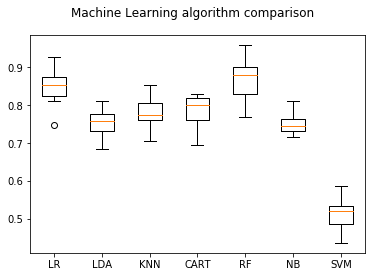

In [210]:
# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Machine Learning algorithm comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [211]:
#Random Forests
clf = RandomForestClassifier(n_estimators = 200, random_state = 10)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=10, verbose=0, warm_start=False)

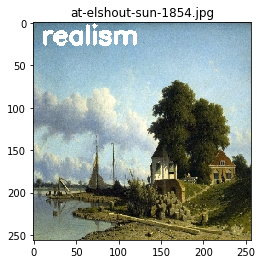

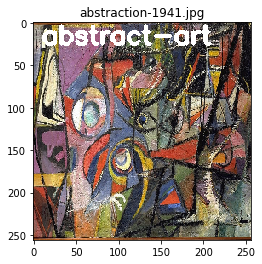

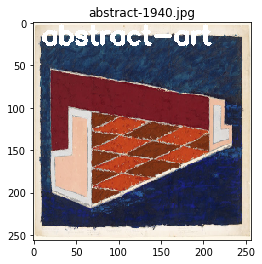

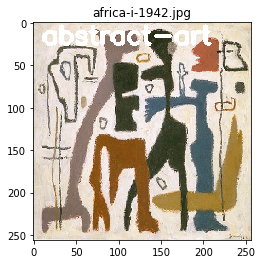

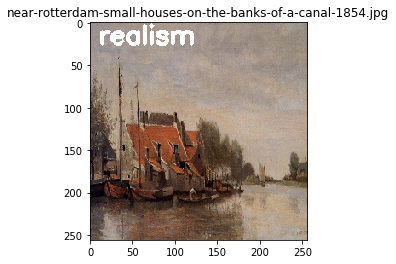

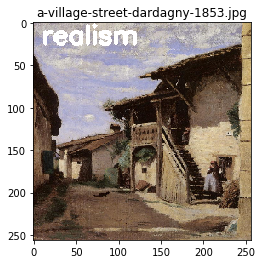

In [217]:
for file in glob.glob(path_validar + "/*.jpg"):
    image = cv.imread(file)
    image = cv.resize(image, tamano)

    hu = hu_moments(image)
    haralick_im   = textura(image)
    histograma_im  = histograma_color(image)

    features_imagen = np.hstack([histograma_im, haralick_im, hu])

    prediction = clf.predict(features_imagen.reshape(1,-1))[0]
    cv2.putText(image, estilos[prediction], (10, 25), cv.FONT_HERSHEY_SIMPLEX, 1.0, (255,255,255), 4)

    plt.imshow(cv.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(file.split('/')[-1])
    plt.show()